### Installing dependencies for preprocessing of images

In [1]:
!pip install imutils



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Helper Functions

In [2]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

C:\Users\0730\AppData\Local\Temp\ipykernel_8068\143107873.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Loading Images

In [19]:
image_dir=r"Z:\INDIRA\Lakshmi\archive (2)\dataset"

### Making directory for augmented images

In [ ]:

os.makedirs('augmented-images')
os.makedirs('augmented-images/training')
os.makedirs('augmented-images/testing')

os.makedirs('augmented-images/training/no')
os.makedirs('augmented-images/training/yes')


os.makedirs('augmented-images/testing/no')
os.makedirs('augmented-images/testing/yes')



## Augmentation of images

In [ ]:
import cv2
import os
from os import listdir
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(file_dir, n_generated_samples, save_to_dir):
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)
        
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image_path = os.path.join(file_dir, filename)
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                # reshape the image
                image = image.reshape((1,)+image.shape)
                save_prefix = 'aug_' + filename[:-4]
                i=0
                for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                    i += 1
                    if i > n_generated_samples:
                        break
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"File not found: {image_path}")



In [ ]:
augmented_data_path =r'augmented-images/'
image_dir="dataset/"
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'Training/no',n_generated_samples=6, save_to_dir=augmented_data_path+'training/no')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'Training/yes', n_generated_samples=9, save_to_dir=augmented_data_path+'training/yes')


Failed to read image: dataset/Training/no\Thumbs.db


In [ ]:
augmented_data_path =r'augmented-images'
image_dir="dataset/"
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'Testing/no',n_generated_samples=6, save_to_dir=augmented_data_path+'testing/no')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'Testing/yes', n_generated_samples=9, save_to_dir=augmented_data_path+'testing/yes')


## Preprocessing the data

## After applying the cropping function

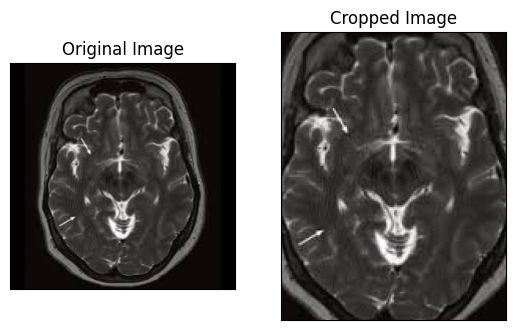

In [21]:
import cv2
import imutils
import matplotlib.pyplot as plt

def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

# Now you can use the function with the image file path
ex_img = cv2.imread('Z:\\INDIRA\\Lakshmi\\archive (2)\\dataset\\Testing\\no\\3 no.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)


In [22]:
import cv2
from os import listdir
import numpy as np
from sklearn.utils import shuffle

def load_data(dir_list, image_size, batch_size=32):
    X = []
    y = []
    image_width, image_height = image_size

    for class_label, directory in enumerate(dir_list):
        filenames = listdir(directory)
        num_files = len(filenames)
        num_batches = num_files // batch_size

        for i in range(num_batches):
            batch_filenames = filenames[i*batch_size: (i+1)*batch_size]
            batch_images = []
            batch_labels = []

            for filename in batch_filenames:
                image = cv2.imread(directory+'/'+filename)
                image = crop_brain_contour(image, plot=False)  # Assuming this function is defined elsewhere
                image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                image = image / 255.

                batch_images.append(image)
                batch_labels.append(class_label)

            X.extend(batch_images)
            y.extend(batch_labels)

    X = np.array(X)
    y = np.array(y)

    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [23]:
dir_list = ['augmented-images/training/no', 'augmented-images/training/yes']
image_size = (50, 50)  # Example image size
X, y = load_data(dir_list, image_size)


Number of examples is: 2880
X shape is: (2880, 50, 50, 3)
y shape is: (2880,)


## Visualization of data

In [28]:
import matplotlib.pyplot as plt

def plot_sample_images(X, y, n=40):
    for label in range(2):  # Loop through four classes
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: {
            0: "no",
            1: "yes",
        }[label]
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


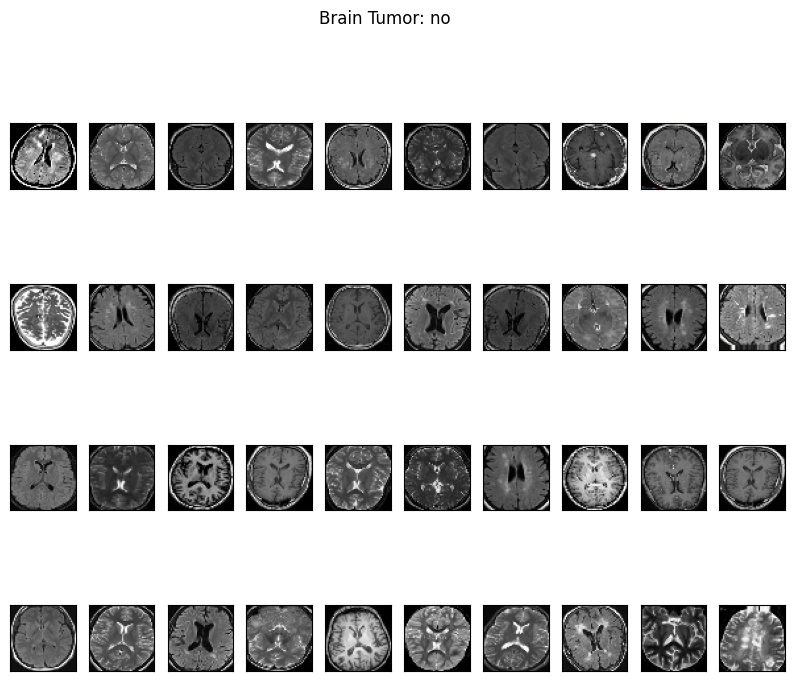

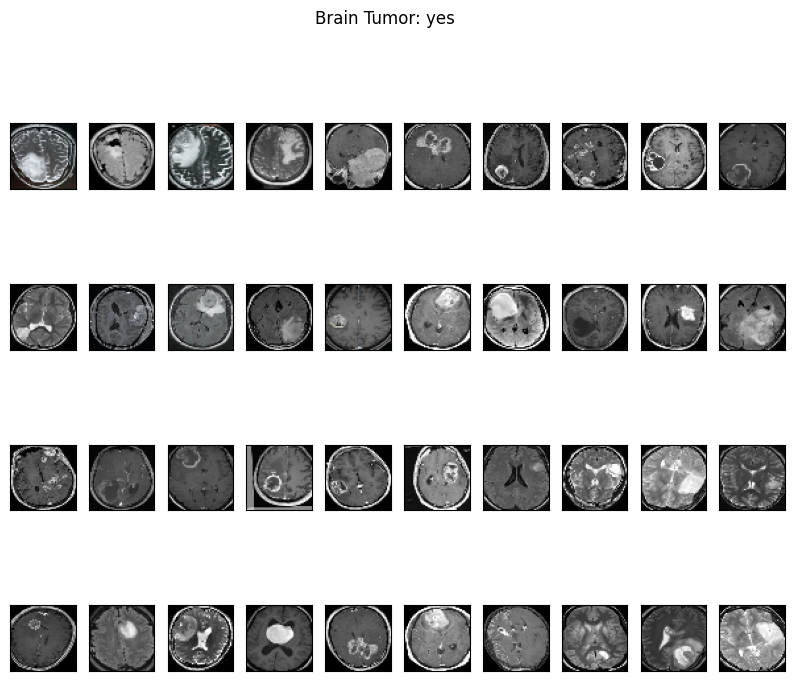

In [29]:
plot_sample_images(X, y)

In [30]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [32]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 2016
number of validation examples = 432
number of test examples = 432


In [11]:



def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)

    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.5)(X)  # Use tf.keras.layers.Dropout instead of Dropout

    X = Dense(4, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X)

    return model

In [33]:

IMG_WIDTH, IMG_HEIGHT = (50, 50)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 54, 54, 3)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,372 (165.52 KB)

 Trainable params: 42,308 (165.27 KB)

 Non-trainable params: 64 (256.00 B)

In [34]:
# from keras.utils.vis_utils import plot_model

# plot_model(model, show_shapes=True, show_layer_names=True)

In [35]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of y_train: (2016,)
Shape of y_val: (432,)


In [36]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [53]:
from tensorflow.keras.utils import to_categorical

# One-hot encode target labels
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

# Then compile and fit your model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])
history =model.fit(x=X_train, y=y_train_encoded, batch_size=32, epochs=50, validation_data=(X_val, y_val_encoded))


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9830 - loss: 0.0449 - precision: 0.9830 - recall: 0.9830 - val_accuracy: 0.9630 - val_loss: 0.1698 - val_precision: 0.9630 - val_recall: 0.9630
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9888 - loss: 0.0408 - precision: 0.9888 - recall: 0.9888 - val_accuracy: 0.9560 - val_loss: 0.1380 - val_precision: 0.9560 - val_recall: 0.9560
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9878 - loss: 0.0317 - precision: 0.9878 - recall: 0.9878 - val_accuracy: 0.9653 - val_loss: 0.1362 - val_precision: 0.9653 - val_recall: 0.9653
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9851 - loss: 0.0442 - precision: 0.9851 - recall: 0.9851 - val_accuracy: 0.9583 - val_loss: 0.1264 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9871 - loss: 0.0385 - precision: 0.9871 - recall: 0.9871 - val_accuracy: 0.9676 - val_loss: 0.1177 

### Plotting of aaccuracy

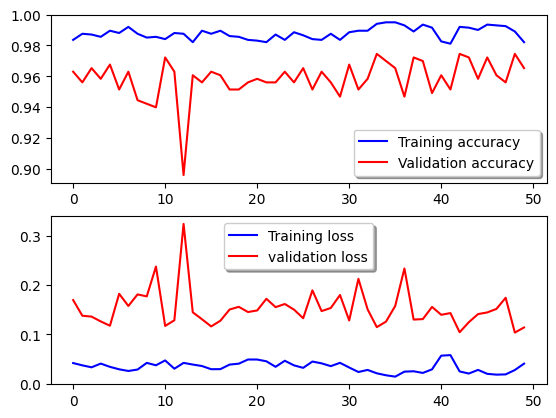

In [56]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True) 

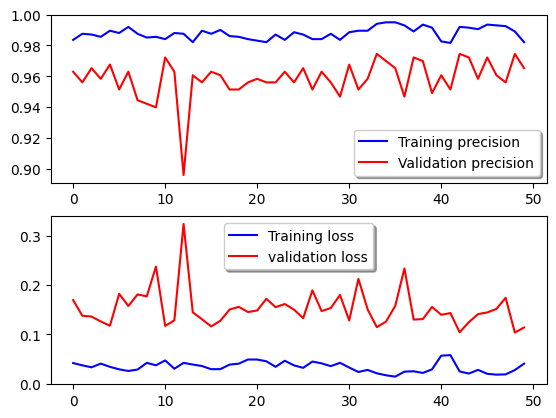

In [57]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['precision'], color='b', label="Training precision")
ax[0].plot(history.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

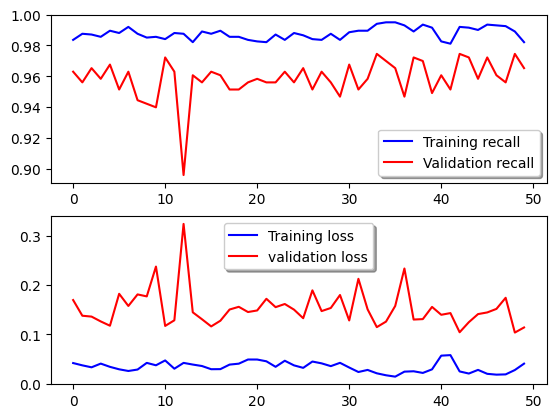

In [58]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['recall'], color='b', label="Training recall")
ax[0].plot(history.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


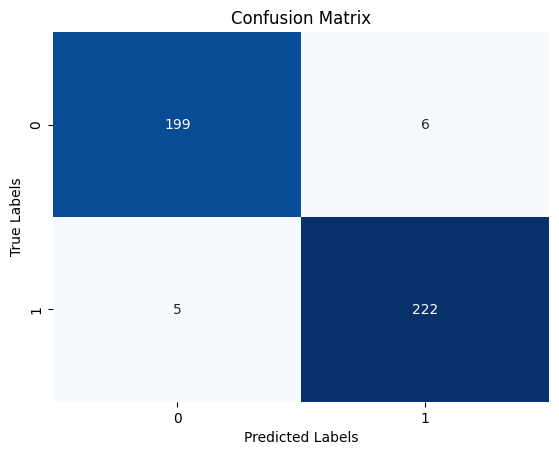

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [60]:
model.save("cnn_1.h5")

## HYBRID MODEL LSTM WITH MOBILENET

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LSTM, Reshape, TimeDistributed
from tensorflow.keras.models import Model

# Define parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 2
lstm_timesteps = 10  # Number of time steps for LSTM

# Prepare data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset\Training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    'dataset\Testing',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False)

# Add LSTM layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((1, -1))(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model with LSTM layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','precision','recall'])

# Train the model
hist=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the trained model
model.save('hybrid_model.h5')


Found 253 images belonging to 2 classes.


Found 253 images belonging to 2 classes.


C:\Users\0730\AppData\Local\Temp\ipykernel_8068\1750491456.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


Epoch 1/10


C:\Users\0730\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6013 - loss: 0.6500 - precision: 0.6013 - recall: 0.6013 - val_accuracy: 0.6875 - val_loss: 0.5267 - val_precision: 0.6875 - val_recall: 0.6875
Epoch 2/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step - accuracy: 0.7188 - loss: 0.4983 - precision: 0.7188 - recall: 0.7188

c:\Program Files\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.7188 - loss: 0.2848 - precision: 0.7188 - recall: 0.7188 - val_accuracy: 1.0000 - val_loss: 0.1588 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8700 - loss: 0.3959 - precision: 0.8700 - recall: 0.8700 - val_accuracy: 0.8884 - val_loss: 0.2907 - val_precision: 0.8884 - val_recall: 0.8884
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.9062 - loss: 0.1585 - precision: 0.9062 - recall: 0.9062 - val_accuracy: 0.7931 - val_loss: 0.1918 - val_precision: 0.7931 - val_recall: 0.7931
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8754 - loss: 0.2709 - precision: 0.8754 - recall: 0.8754 - val_accuracy: 0.9152 - val_loss: 0.2061 - val_precision: 0.9152 - val_recall: 0.9152
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9375 - loss: 0.0798 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.8621 - val_loss: 0.1474 - val_precision: 0.8

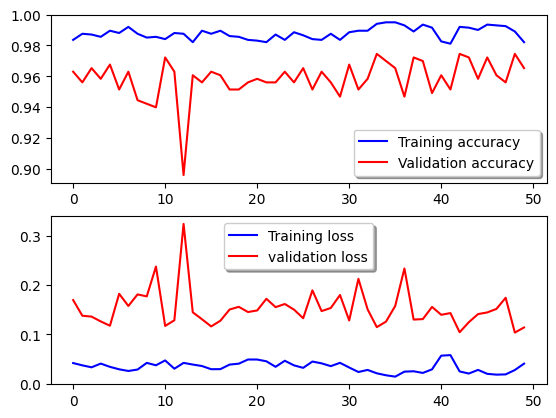

In [63]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True) 

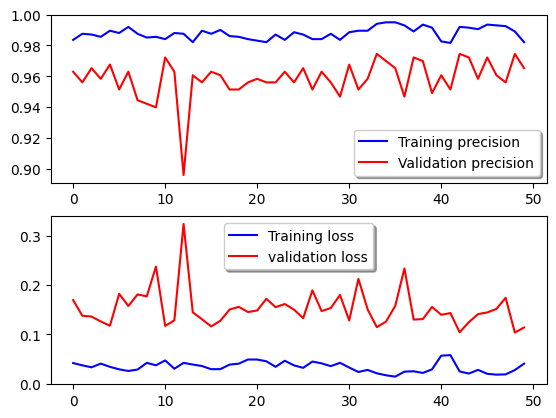

In [64]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['precision'], color='b', label="Training precision")
ax[0].plot(history.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)


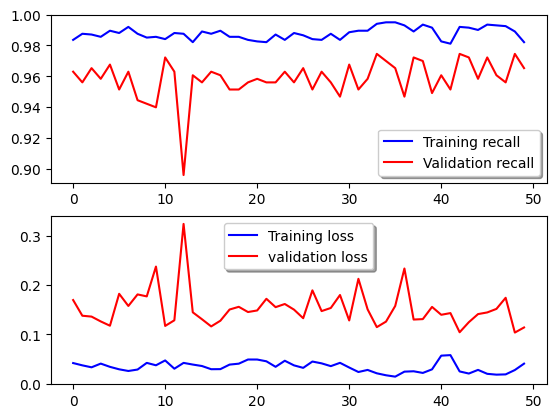

In [65]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['recall'], color='b', label="Training recall")
ax[0].plot(history.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['loss'], color='b', label="Training loss")
ax[1].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 781ms/step
Accuracy: 0.9446640316205533


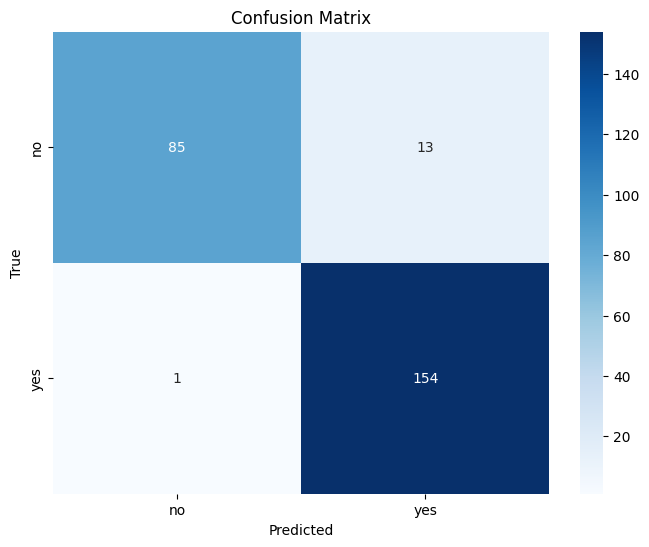

Classification Report:
              precision    recall  f1-score   support

          no       0.99      0.87      0.92        98
         yes       0.92      0.99      0.96       155

    accuracy                           0.94       253
   macro avg       0.96      0.93      0.94       253
weighted avg       0.95      0.94      0.94       253



In [74]:
from sklearn.metrics import confusion_matrix, classification_report
# Make predictions
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

SVM

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_dir=r"dataset\Training"
test_dir=r"dataset\Testing"

In [6]:
data_dir = r"dataset\Training"
Brain=[]
for file in os.listdir(data_dir):
    Brain+=[file]
print(Brain)
print(len(Brain))

['no', 'yes']
2


In [7]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()

In [8]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [9]:
img_height,img_width=256,256
batch_size=20

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')
test_generator = train_datagen.flow_from_directory(test_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [10]:
from tensorflow import keras
from tensorflow.keras.regularizers import l2

In [11]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(img_height,img_width,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(2,kernel_regularizer=l2(0.01),activation = "softmax"))
model.summary()

C:\Users\0730\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,204,834 (16.04 MB)

 Trainable params: 4,204,834 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer="adam",loss="squared_hinge",metrics=['accuracy',precision,recall])
hist=model.fit(train_generator,epochs=10,validation_data=test_generator)

Epoch 1/10


C:\Users\0730\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 913ms/step - accuracy: 0.6832 - loss: 1.1145 - precision: 0.6832 - recall: 0.6832 - val_accuracy: 0.8300 - val_loss: 0.8831 - val_precision: 0.8300 - val_recall: 0.8300
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.8095 - loss: 0.9170 - precision: 0.8095 - recall: 0.8095 - val_accuracy: 0.8577 - val_loss: 0.8319 - val_precision: 0.8577 - val_recall: 0.8577
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.8386 - loss: 0.8497 - precision: 0.8386 - recall: 0.8386 - val_accuracy: 0.8775 - val_loss: 0.7774 - val_precision: 0.8775 - val_recall: 0.8775
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.8903 - loss: 0.7706 - precision: 0.8903 - recall: 0.8903 - val_accuracy: 0.9249 - val_loss: 0.6998 - val_precision: 0.9249 - val_recall: 0.9249
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.9018 - loss: 0.7275 - precision: 0.9018 - recall: 0.9018 - val_accuracy: 0.9289 - val_loss: 0.6775 - val

In [13]:
model.evaluate(test_generator)
model.save("models/SVM.h5")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9715 - loss: 0.5819 - precision: 0.9715 - recall: 0.9715


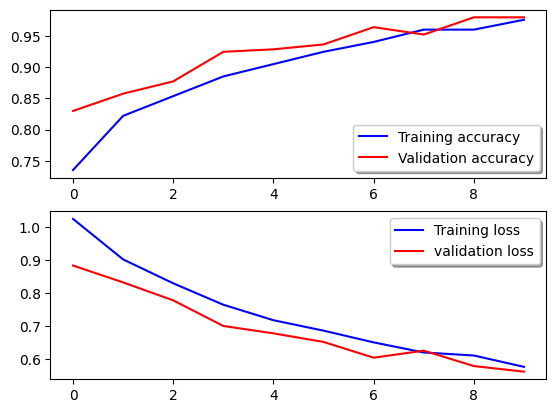

In [17]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

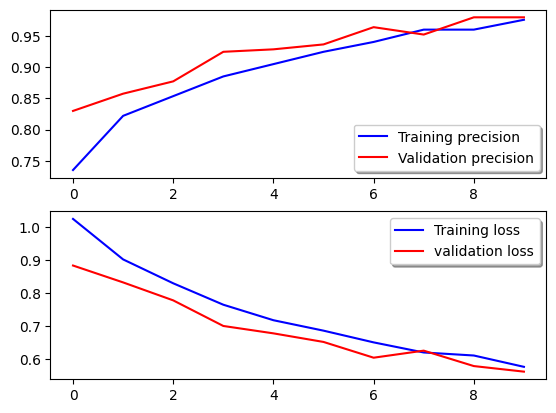

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)


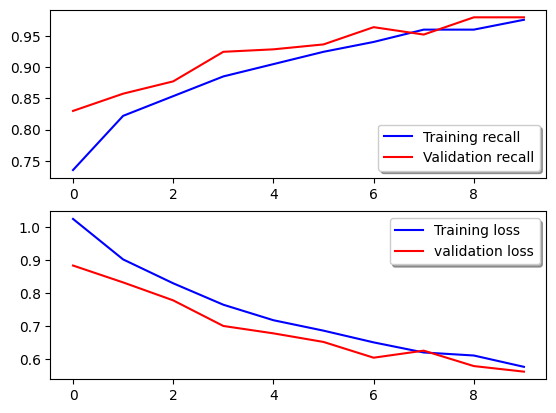

In [20]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['recall'], color='b', label="Training recall")
ax[0].plot(hist.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step
Accuracy: 0.5533596837944664


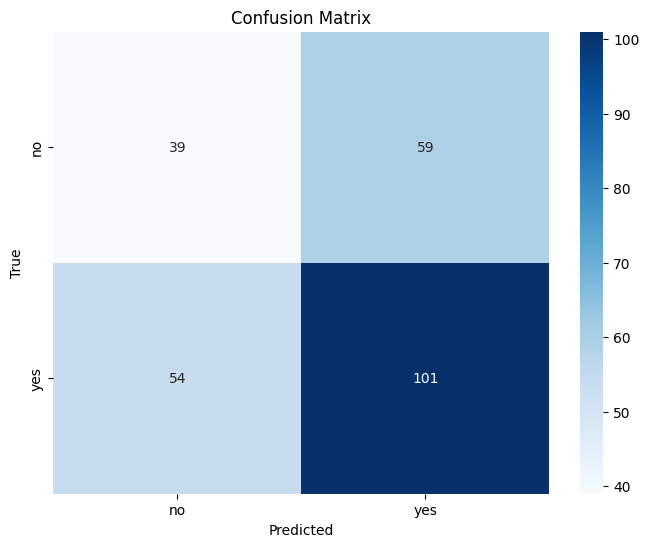

Classification Report:
              precision    recall  f1-score   support

          no       0.42      0.40      0.41        98
         yes       0.63      0.65      0.64       155

    accuracy                           0.55       253
   macro avg       0.53      0.52      0.52       253
weighted avg       0.55      0.55      0.55       253



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))